Getting Records from UN Digital Library

In [1]:
# Python Libraries required in this section
import requests
# Json to work with data in JSON
import json
# To parse and work with XML
import xml.etree.ElementTree as ET

UTILIZE UNDL API TO EXTRACT RESOLUTIONS SPONSORED/CO-SPONSORED BY MEMBER STATE

In [2]:
# Python libraries
import time
import xml.etree.ElementTree as ET
import requests

# Function
def get_records_xml(params, api_key, check=1000):
    """
    Fetches all records from the UN Digital Library API.

    Args:
        params (dict): The parameters to be sent with the API request.
        api_key (str): The API key for authentication.
        check (int, optional): Number of records to fetch before printing status. Defaults to 1000.

    Returns:
        xml.etree.ElementTree.ElementTree: The XML tree containing all the records.
    """

    # Initialize variables
    url = "https://digitallibrary.un.org/api/v1/search?"
    search_id = None
    total = None
    root = ET.Element("collection")
    all_records = []

    # Fetch records in a loop until there are no more records
    while True:
        if search_id:
            # If search_id exists, add it to the request parameters
            params['search_id'] = search_id
        else:
            # If search_id doesn't exist, create a copy of the original params
            params = params.copy()

        # Make the HTTP GET request to fetch the MARC XML data
        r = requests.get(url,
                         params=params,
                         headers={
                             "content-type": "application/xml",
                             "Authorization": "Token {}".format(api_key)
                         })
        
        # Check if the request was successful
        if r.status_code != 200:
            if r.status_code == 429:
                print("Let's wait 5 minutes! Too many requests, they say!")
                time.sleep(300)  # Wait for 5 minutes
                print("Let's try again!")
                r = requests.get(url,
                         params=params,
                         headers={
                             "content-type": "application/xml",
                             "Authorization": "Token {}".format(api_key)
                         })
            else:
                print(f"Error: Received status code {r.status_code}")
                break

        # Parse the response XML and remove the namespace
        try:
            response = ET.fromstring(
                r.text.replace('xmlns="http://www.loc.gov/MARC21/slim"', ''))
        except ET.ParseError as e:
            print("ParseError:", e)
            print("Response text:", r.text)
            break

        # Get the search_id from the response
        search_id = response.find('search_id').text
        
        # Get and print total number of records if total = None
        if not total:
            total = response.find('total').text
            print("Total nb. of records: " + total)

        # Find the collection element in the response
        collection = response.find('collection')

        # If there are no records in the collection, exit the loop
        if len(collection) == 0:
            break

        # Append each record to the list of all records
        for record in collection.findall("record"):
            all_records.append(record)
        
        # Print the number of records fetched
        if len(all_records) % check == 0:
            print("Nb. of records processed: " + str(len(all_records)))

    # Append all the records to the root element
    for record in all_records:
        root.append(record)
    # Create a new XML tree with the root element
    new_xml_tree = ET.ElementTree(root)

    # Return the XML tree containing all the records
    return new_xml_tree

In [3]:
apikey = 'fd482a33-85cf-4a37-a955-93b4f5d6f1fb'
member = "saudi arabia"
date = "2019-01-01"
parameters= {"format": "xml",
        "c": "Documents and Publications",
        "p":f'989:"resolutions" AND (245%%c:{member} OR 515:{member}) AND 269:>={date}'
       }
# call the function
all_records = get_records_xml(parameters, apikey)

Total nb. of records: 314


In [4]:
# Type of data in all_records
type(all_records)

xml.etree.ElementTree.ElementTree

In [5]:
# Length -> number of records in all_records
len(all_records.getroot())

314

In [6]:
# Specify the file path where you want to save the XML data
xml_file_path = f"{member}.xml"

In [7]:
# Save the ElementTree object to an XML file
all_records.write(xml_file_path, encoding="utf-8")

In [8]:
import xml.etree.ElementTree as ET
import pandas as pd

def marcxml_to_dataframe(xml_tree):
    """
    Parses MARC XML and returns two DataFrames:
    1. Full DataFrame with all fields
    2. Filtered DataFrame with selected fields and one-hot encoded 650_a
    """

    # Define desired fields
    selected_fields = {
        "controlfield_000",
        "datafield_191_a",
        "datafield_245_a",
        "datafield_245_b",
        "datafield_245_c",
        "datafield_269_a",
        "datafield_710_a",
        "datafield_239_a",
    }

    root = xml_tree.getroot()
    full_records = []
    filtered_records = []
    all_650_categories = []
    all_991_categories = []

    for record in root.findall("record"):
        full_flat = {}
        filtered_flat = {}
        categories_650 = []
        categories_991 = []

        # Controlfields
        for cf in record.findall("controlfield"):
            tag = cf.attrib.get("tag")
            key = f"controlfield_{tag}"
            value = cf.text
            if value:
                full_flat[key] = value
                if key in selected_fields:
                    filtered_flat[key] = value

        # Datafields
        for df in record.findall("datafield"):
            tag = df.attrib.get("tag")
            for sf in df.findall("subfield"):
                code = sf.attrib.get("code")
                key = f"datafield_{tag}_{code}"
                value = sf.text
                if not value:
                    continue
                # Accumulate values in case of repeats
                full_flat[key] = full_flat.get(key, "") + (" | " if key in full_flat else "") + value
                if key in selected_fields:
                    filtered_flat[key] = filtered_flat.get(key, "") + (" | " if key in filtered_flat else "") + value
                if key == "datafield_650_a":
                    categories_650.append(value.strip())
                if key == "datafield_991_c":
                    categories_991.append(value.strip())

        full_records.append(full_flat)
        filtered_records.append(filtered_flat)
        all_650_categories.append(categories_650)
        all_991_categories.append(categories_991)

    # Build DataFrames
    df_full = pd.DataFrame(full_records)
    df_filtered = pd.DataFrame(filtered_records)

    # One-hot encode 650_a
    df_650 = (
        pd.Series(all_650_categories)
        .explode()
        .dropna()
        .str.strip()
        .str.get_dummies()
        .groupby(level=0)
        .sum()
    )

    df_991 = (
        pd.Series(all_991_categories)
        .explode()
        .dropna()
        .str.strip()
        .str.get_dummies()
        .groupby(level=0)
        .sum()
    )

    df_filtered = df_filtered.join(df_991)
    
    df_filtered = df_filtered.join(df_650)

    onehot_650_cols = df_650.columns.tolist()
    onehot_991_cols = df_991.columns.tolist()
    return df_full, df_filtered, onehot_650_cols, onehot_991_cols



In [9]:
# Convert the MARC XML records to a DataFrame
df_raw, df_processed, onehot_650_cols, onehot_991_cols= marcxml_to_dataframe(all_records)

df_raw.drop_duplicates(inplace=True)
df_processed.drop_duplicates(inplace=True)

mask = (df_raw['datafield_245_a'] == 'Draft resolution /') & (df_raw['datafield_239_a'].notnull())
df_raw.loc[mask, 'datafield_245_a'] = df_raw.loc[mask, 'datafield_239_a']

mask = (df_processed['datafield_245_a'] == 'Draft resolution /') & (df_processed['datafield_239_a'].notnull())
df_processed.loc[mask, 'datafield_245_a'] = df_processed.loc[mask, 'datafield_239_a']

sheet ="raw"

excel_path = f"{member}/{member}_undl.xlsx"
# Export to Excel
df_raw.to_excel(excel_path, sheet_name=sheet, index=False)

# Print a preview
df_raw.head()

,controlfield_000,controlfield_001,controlfield_005,controlfield_008,datafield_029_a,datafield_029_b,datafield_035_a,datafield_039_a,datafield_040_a,datafield_040_b,...,datafield_611_2,datafield_611_a,datafield_611_0,datafield_239_a,datafield_500_a,datafield_089_a,datafield_909_o,datafield_909_p,datafield_246_a,datafield_246_b
0,03168nam a2200661#a 4500,3799834,20190425221951.0,190415s2019 che #r ||| | eng d,JN,G1904612 E,(DHL)1214535,GUN,SzGeBNU,eng,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000nam a2200025#a 4500,3806908,20240821095701.0,190603s2019 usa #r |||1| eng d,JN,N1908798 E,(DHL)1220308,DHU,NNUN,eng,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000nam a2200025#a 4500,3807201,20210223191227.0,190604s2019 usa #r |||1| eng d,JN,N1908857 E,(DHL)1220603,DHU,NNUN,eng,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,02039nam a2200457#a 4500,3824632,20190827113254.0,190823s2019 che #r ||| | eng d,JN,G1911662 E,(DHL)1228651,GUN,SzGeBNU,eng,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,02039nam a2200457#a 4500,3824633,20190827113259.0,190823s2019 che #r ||| | eng d,JN,G1911664 E,(DHL)1228652,GUN,SzGeBNU,eng,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
sheet = "processed"
# Export the processed DataFrame to Excel
with pd.ExcelWriter(excel_path, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df_processed.to_excel(writer, sheet_name=sheet, index=False)
# Print a preview of the processed DataFrame
df_processed.head()

,controlfield_000,datafield_191_a,datafield_245_a,datafield_245_b,datafield_245_c,datafield_269_a,datafield_710_a,datafield_239_a,Advancement of women.,"Agriculture development, food security and nutrition.",...,WOMEN,WOMEN WORKERS,WOMEN'S ADVANCEMENT,WOMEN'S HEALTH,WOMEN'S RIGHTS,WOMEN'S STATUS,WORKING GROUPS,XENOPHOBIA,YEMEN,YOUTH
0,03168nam a2200661#a 4500,A/HRC/40/L.30,Recognizing the contribution of environmental ...,amendment to draft resolution A/HRC/40/L.22/Re...,"China, Egypt, Pakistan, Saudi Arabia, Venezuel...",2019-03-20,China | Egypt | Pakistan | Saudi Arabia | Vene...,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000nam a2200025#a 4500,A/73/L.88,Enhancement of international cooperation to as...,draft resolution /,"Afghanistan, Australia, Canada, Egypt, Equator...",2019-05-29,Afghanistan | Australia | Canada | Egypt | Equ...,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000nam a2200025#a 4500,E/2019/L.12,United Nations Institute for Training and Rese...,draft resolution /,"Bahrain, Dominican Republic, Ecuador, Guatemal...",2019-05-30,Bahrain | Dominican Republic | Ecuador | Guate...,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,02039nam a2200457#a 4500,A/HRC/41/L.40,"Consequences of child, early and forced marria...",amendment to draft resolution A/HRC/41/L.8/Rev...,"Bahrain, Saudi Arabia",2019-07-10,Bahrain | Saudi Arabia,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,02039nam a2200457#a 4500,A/HRC/41/L.42,"Consequences of child, early and forced marria...",amendment to draft resolution A/HRC/41/L.8/Rev...,"Egypt, Iraq, Saudi Arabia",2019-07-10,Egypt | Iraq | Saudi Arabia,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
id_vars = [col for col in df_processed.columns if col not in onehot_650_cols and col not in onehot_991_cols]

# Melt the DataFrame
df_long = pd.melt(df_processed, id_vars=id_vars, value_vars=onehot_650_cols,
                  var_name="Key Words", value_name="Flag")

# Keep only active categories
df_long = df_long[df_long["Flag"] == 1]
df_long.drop(columns=["Flag"], inplace=True)

df_melt = pd.melt(df_processed, id_vars='datafield_191_a', value_vars=onehot_991_cols,
                  var_name = 'Agenda', value_name='Flag')
df_melt = df_melt[df_melt['Flag'] == 1]
df_melt.drop(columns=['Flag'], inplace=True)

df_long = df_long.merge(df_melt, on='datafield_191_a', how='left')

df_long['Year'] = pd.to_datetime(df_long['datafield_269_a'], errors='coerce').dt.year
df_long["Key Words"] = df_long["Key Words"].str.title()

sheet = "long"
# Export the processed DataFrame to Excel
with pd.ExcelWriter(excel_path, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df_long.to_excel(writer, sheet_name=sheet, index=False)
# Print a preview of the processed DataFrame
df_long

,controlfield_000,datafield_191_a,datafield_245_a,datafield_245_b,datafield_245_c,datafield_269_a,datafield_710_a,datafield_239_a,Key Words,Agenda,Year
0,00000nam a2200025#a 4500,A/77/L.37,Promoting and mainstreaming easy-to-understand...,draft resolution /,"Argentina, Brazil, Dominican Republic, Egypt, ...",2022-12-08,Argentina | Brazil | Dominican Republic | Egyp...,NaN,Access To Information,Promotion and protection of human rights.,2022
1,00000nam a2200025#a 4500,A/77/L.37,Promoting and mainstreaming easy-to-understand...,draft resolution /,"Argentina, Brazil, Dominican Republic, Egypt, ...",2022-12-08,Argentina | Brazil | Dominican Republic | Egyp...,NaN,Accessibility,Promotion and protection of human rights.,2022
2,02039nam a2200457#a 4500,A/HRC/42/L.12,Technical assistance and capacity-building for...,draft resolution /,"Algeria, Bahrain, Comoros, Djibouti, Egypt, Ir...",2019-09-24,Algeria | Bahrain | Comoros | Djibouti | Egypt...,NaN,Accountability,Technical assistance and capacity-building.,2019
3,02039nam a2200457#a 4500,A/HRC/42/L.8,The use of mercenaries as a means of violating...,draft resolution /,"Algeria, Belarus, Bolivia (Plurinational State...",2019-09-24,Algeria | Belarus | Bolivia (Plurinational Sta...,NaN,Accountability,"Promotion and protection of all human rights, ...",2019
4,02039nam a2200457#a 4500,A/HRC/42/L.23,Terrorism and human rights :,draft resolution /,"Algeria, Egypt, Georgia, Jordan, Mexico, Saudi...",2019-09-23,Algeria | Egypt | Georgia | Jordan | Mexico | ...,NaN,Accountability,"Promotion and protection of all human rights, ...",2019
...,...,...,...,...,...,...,...,...,...,...,...
1360,02039nam a2200457#a 4500,A/HRC/42/L.12,Technical assistance and capacity-building for...,draft resolution /,"Algeria, Bahrain, Comoros, Djibouti, Egypt, Ir...",2019-09-24,Algeria | Bahrain | Comoros | Djibouti | Egypt...,NaN,Yemen,Technical assistance and capacity-building.,2019
1361,02039nam a2200457#a 4500,A/HRC/45/L.51,Technical assistance and capacity-building for...,draft resolution /,"Bahrain, Egypt, Kuwait, Mauritania, Saudi Arab...",2020-10-01,Bahrain | Egypt | Kuwait | Mauritania | Saudi ...,NaN,Yemen,Technical assistance and capacity-building.,2020
1362,03168nam a2200661#a 4500,A/HRC/51/L.38,Technical assistance and capacity-building for...,draft resolution /,"Algeria, Bahrain, Comoros, Djibouti, Egypt, Ir...",2022-10-04,Algeria | Bahrain | Comoros | Djibouti | Egypt...,NaN,Yemen,Technical assistance and capacity-building.,2022
1363,02039nam a2200457#a 4500,A/HRC/41/L.19,Youth and human rights :,draft resolution /,"Albania, Algeria, Armenia, Australia, Austria,...",2019-07-09,Albania | Algeria | Armenia | Australia | Aust...,NaN,Youth,"Promotion and protection of all human rights, ...",2019


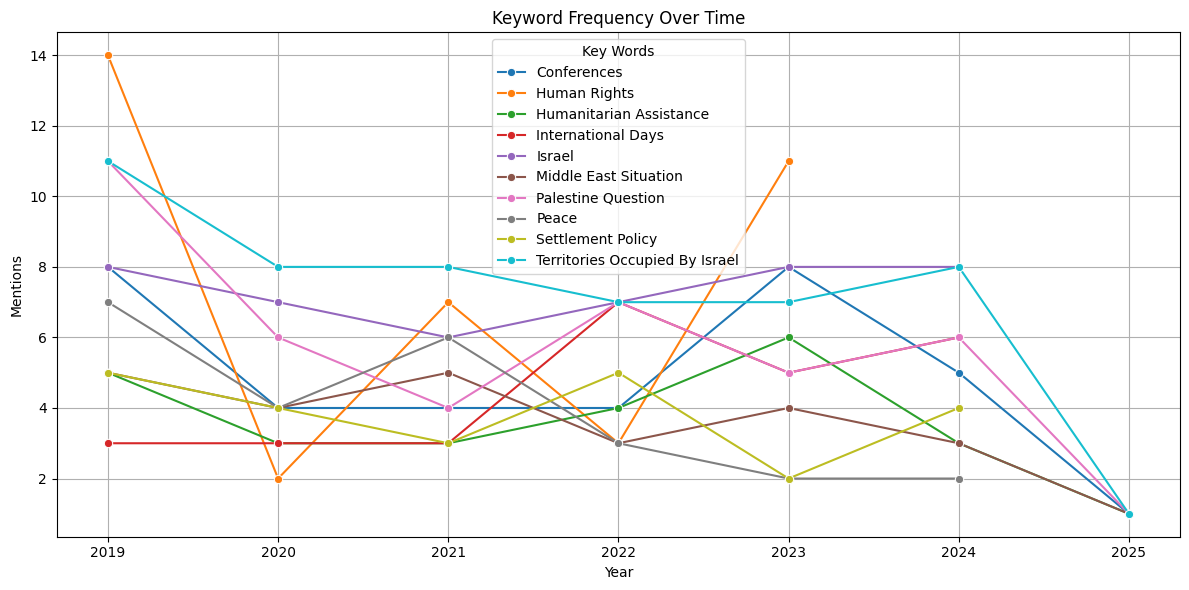

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

df_long['datafield_269_a'] = pd.to_datetime(df_long['datafield_269_a'], errors='coerce')
df_long['Year'] = df_long['datafield_269_a'].dt.year
df_counts = df_long.groupby(["Year", "Key Words"]).size().reset_index(name="count")

top_keywords = df_counts.groupby("Key Words")["count"].sum().nlargest(10).index
df_plot = df_counts[df_counts["Key Words"].isin(top_keywords)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x="Year", y="count", hue="Key Words", marker="o")
plt.title("Keyword Frequency Over Time")
plt.xlabel("Year")
plt.ylabel("Mentions")
plt.grid(True)
plt.tight_layout()
plt.show()